# SAM: Sharpness-Aware Minimization for Efficiently Improving Generalization

by Pierre Foret, Ariel Kleiner, Hossein Mobahi and Behnam Neyshabur.

Reproduce by Group 11.

### Lưu ý một số thư viện không còn hỗ trợ trên framework JAX nên bài này chạy Pytorch

## Kết nối với Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Master/CS2229.CH200/SourceCode/sam_pytorch/example"

/content/drive/.shortcut-targets-by-id/1vqFBK5B5wUmjCWGH5o_mUThVAt8qf6ME/CS2229.CH200/SourceCode/sam_pytorch/example


## Trực quan hóa quá trình training cho tới hiện tại


Đọc dữ liệu thành công.


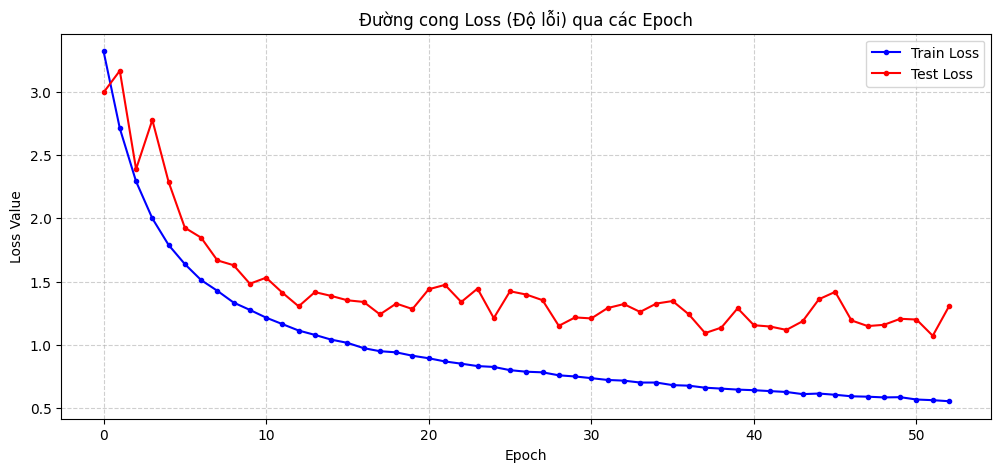

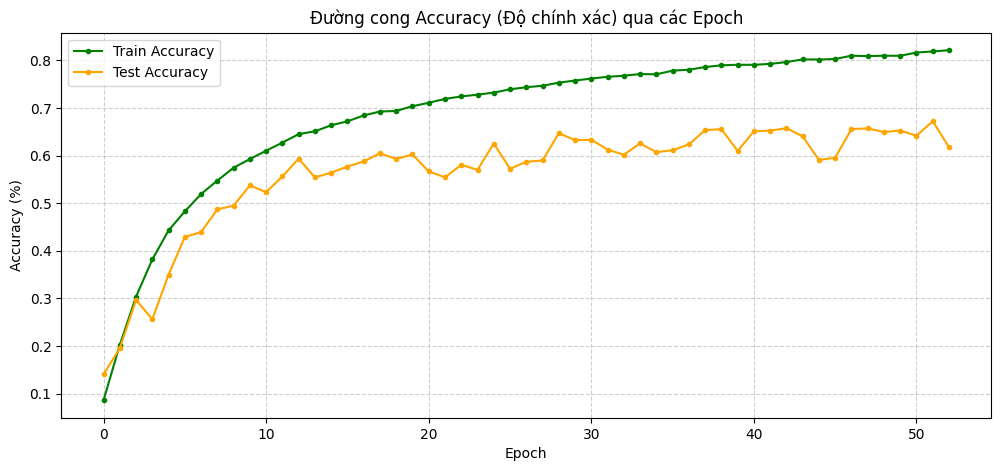

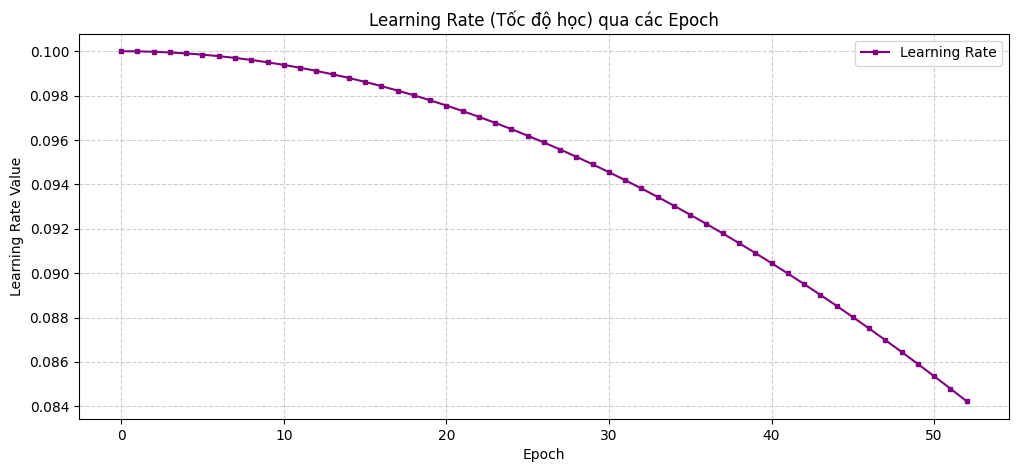

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# 2. Định nghĩa đường dẫn tới file log
FILE_PATH = '/content/drive/MyDrive/Master/CS2229.CH200/SourceCode/sam_pytorch/example/checkpoints/WRN-28-10_CIFAR-100-SAM/Log[WRN-28-10_CIFAR-100-SAM].csv'

# 3. Đọc dữ liệu từ file CSV
try:
    df = pd.read_csv(FILE_PATH)
    print("\nĐọc dữ liệu thành công.")
    # print(df.head())
except FileNotFoundError:
    print(f"\nLỖI: Không tìm thấy file tại đường dẫn: {FILE_PATH}")
    print("Vui lòng kiểm tra lại đường dẫn và đảm bảo file tồn tại.")
    exit()
except Exception as e:
    print(f"\nLỖI khi đọc file CSV: {e}")
    exit()

# Kiểm tra và xử lý dữ liệu: Nếu có nhiều dòng cho cùng 1 Epoch, ta sẽ lấy giá trị trung bình
# để đảm bảo mỗi Epoch chỉ có 1 điểm trên đồ thị
df_agg = df.groupby('Epoch', as_index=False).mean()

# =================================================================
# 4. Trực quan hóa kết quả
# =================================================================

# 4.1. Biểu đồ Loss (Độ lỗi)
plt.figure(figsize=(12, 5))
plt.plot(df_agg['Epoch'], df_agg['Train_Loss'], label='Train Loss', marker='o', markersize=3, color='blue')
plt.plot(df_agg['Epoch'], df_agg['Test_Loss'], label='Test Loss', marker='o', markersize=3, color='red')

plt.title('Đường cong Loss (Độ lỗi) qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 4.2. Biểu đồ Accuracy (Độ chính xác)
plt.figure(figsize=(12, 5))
plt.plot(df_agg['Epoch'], df_agg['Train_Acc'], label='Train Accuracy', marker='o', markersize=3, color='green')
plt.plot(df_agg['Epoch'], df_agg['Test_Acc'], label='Test Accuracy', marker='o', markersize=3, color='orange')

plt.title('Đường cong Accuracy (Độ chính xác) qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 4.3. Biểu đồ Learning Rate (Tốc độ học) - Nếu có thay đổi
# Biểu đồ này giúp kiểm tra Learning Rate Scheduler có hoạt động đúng không
plt.figure(figsize=(12, 5))
plt.plot(df_agg['Epoch'], df_agg['Learning_Rate'], label='Learning Rate', marker='s', markersize=3, color='purple')

plt.title('Learning Rate (Tốc độ học) qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Đọc log để xem best checkpoint là epoch mấy (Cho tới hiện tại)

In [5]:
import pandas as pd
import os

# 1. Đường dẫn file (như bạn cung cấp)
file_path = "/content/drive/MyDrive/Master/CS2229.CH200/SourceCode/sam_pytorch/example/checkpoints/WRN-28-10_CIFAR-100-SAM/Log[WRN-28-10_CIFAR-100-SAM].csv"

# Kiểm tra xem file có tồn tại không để tránh lỗi
if os.path.exists(file_path):
    # 2. Đọc file CSV
    df = pd.read_csv(file_path)

    # In ra tên các cột để bạn dễ kiểm tra nếu code báo lỗi tên cột
    # print(f"Các cột có trong file log: {list(df.columns)}")

    # 3. Xác định tên cột Test Accuracy
    possible_names = ["Test_Acc"]

    target_col = None
    for name in possible_names:
        if name in df.columns:
            target_col = name
            break

    if target_col:
        # 4. Tìm dòng có accuracy cao nhất
        best_row = df.loc[df[target_col].idxmax()]

        best_epoch = int(best_row['Epoch']) if 'Epoch' in df.columns else int(best_row.name)
        best_acc = best_row[target_col]

        print("-" * 30)
        print(f"Kết quả tốt nhất tìm được trên tập Test:")
        print(f"► Epoch: {best_epoch}")
        print(f"► Accuracy: {best_acc}")
        print("-" * 30)
    else:
        print("Lỗi: Không tìm thấy cột nào tên là 'test_acc' hay tương tự. Hãy kiểm tra lại danh sách cột in ở trên.")

else:
    print(f"Lỗi: Không tìm thấy file tại đường dẫn: {file_path}")

------------------------------
Kết quả tốt nhất tìm được trên tập Test:
► Epoch: 51
► Accuracy: 0.672
------------------------------


## Training mô hình

In [ ]:
# Cell này để test nhanh flow (Sanity Check)
# !python train.py --name test_flow5 --epoch 200 --width_factor 1 --depth 2 --lr_schedule StepLR --save_after 10

In [ ]:
!python train.py --name  WRN-28-10_CIFAR-100-SAM --dataset cifar100 --minimizer SAM --batch_size 256 --depth 28 --width_factor 10 --adaptive False --rho 0.05 --weight_decay 0.0005  --save_after 1

--> Optimizer: SAM
Using Cosine LR Schedule
--> Found checkpoint in WRN-28-10_CIFAR-100-SAM: checkpoints/WRN-28-10_CIFAR-100-SAM/ckpt_epoch_48.pth. Loading...
--- DEBUG: KIỂM TRA TRẠNG THÁI SAM/SGD ---
Trạng thái (state) của tham số đầu tiên (kích thước torch.Size([16, 3, 3, 3])):
{
    "momentum_buffer": "Tensor(size=torch.Size([16, 3, 3, 3]), value=[-0.008484717458486557, -0.010306423529982567, -0.009699167683720589, -0.016754578799009323, -0.01395323220640421])",
    "old_p": "Tensor(size=torch.Size([16, 3, 3, 3]), value=[0.0696791559457779, 0.12338466197252274, 0.12233012169599533, 0.040126603096723557, -0.026738280430436134])"
}

-> FOUND: 'momentum_buffer' (Standard SGD key)
--> Random states restored successfully.
--> Resuming training from epoch 49
┏━━━━━━━━━━━━━━┳━━━━━━━╸T╺╸R╺╸A╺╸I╺╸N╺━━━━━━━┳━━━━━━━╸S╺╸T╺╸A╺╸T╺╸S╺━━━━━━━┳━━━━━━━╸V╺╸A╺╸L╺╸I╺╸D╺━━━━━━━┓
┃              ┃              ╷              ┃              ╷              ┃              ╷              ┃
┃       epoch  ┃   